In [1]:
import re
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [4]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [5]:
query_dir = 'queries'

In [6]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [7]:
query_client = bigquery.Client()

In [8]:
request = queries['combined_analysis_data.sql']

In [9]:
data = query_client.query(request).to_dataframe()

In [10]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [11]:
data['post_code'] = data.address.apply(get_postcode_from_address)

In [12]:
data['price_per_sq_m'] = data.price / data.primary_size

In [13]:
data['lat_bin'] = pd.cut(data['lat'], bins=15, precision=5)
data['lng_bin'] = pd.cut(data['lng'], bins=15, precision=5)

In [14]:
post_codes_no = pd.read_csv('post_codes_no.csv', dtype={'post_code': str}).set_index('post_code')

In [15]:
data['settlement_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_no, how='left', left_on='post_code', right_index=True)['municipality']

In [16]:
post_codes_osl = pd.read_csv('post_codes.csv', dtype={'post_code':str}).set_index('post_code', drop=True)

In [17]:
data['neighborhood_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_osl, how='left', left_on='post_code', right_index=True)['neighborhood_name']

In [18]:
data['area_name'] = [settlement if settlement != 'OSLO' else neighborhood
                     for settlement, neighborhood
                     in zip(data['settlement_name'], data['neighborhood_name'])]

In [19]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'OSLO' else False)

/Users/ruslan.kozhuharov/venvs/home_oslo_home/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ruslan.kozhuharov/venvs/home_oslo_home/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


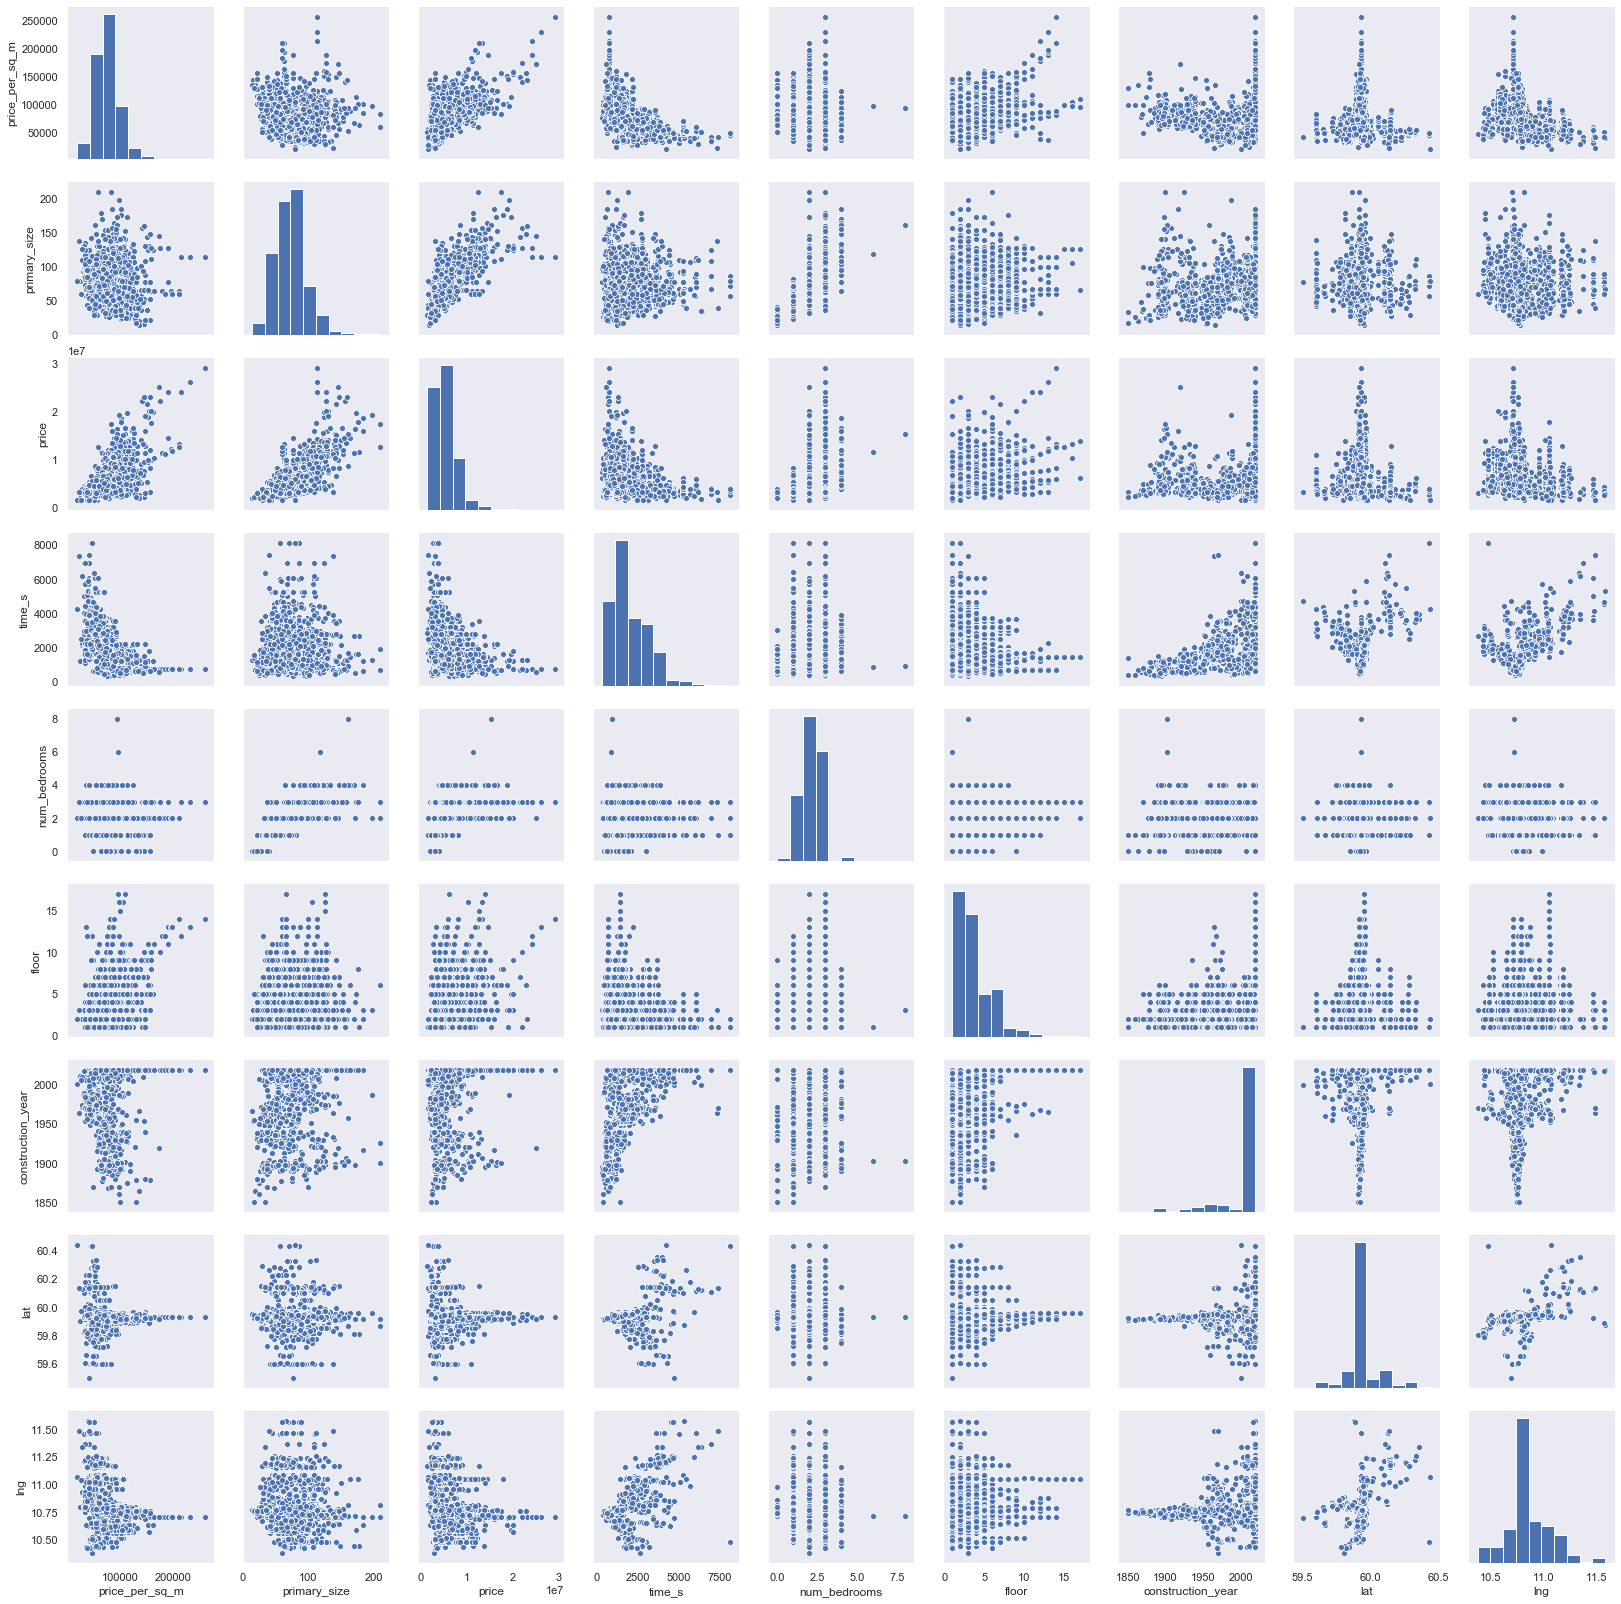

In [38]:
to_plot = data[['price_per_sq_m', 'primary_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year', 'lat', 'lng', 'property_type']]
sns.pairplot(data=to_plot[to_plot.property_type == 'Leilighet'])

In [20]:
scaler = MinMaxScaler()
data['price_per_sq_m_scaled'] = scaler.fit_transform(data['price_per_sq_m'].to_frame())

In [21]:
# data.set_index(['ad_id', 'apt_id'], drop=True)

In [22]:
data['construction_year_bin'] = pd.cut(data['construction_year'], bins=15, precision=0)

In [23]:
data['time_s_bin'] = pd.cut(data['construction_year'], bins=15, precision=0)

In [24]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,brokerage_expenses,common_wealth,common_debt,time_s,lat,lng,address,short_description,full_description,energy_letter,energy_color,post_code,price_per_sq_m,lat_bin,lng_bin,settlement_name,neighborhood_name,area_name,address_oslo,price_per_sq_m_scaled,construction_year_bin,time_s_bin
0,69757913,34,True,2.0,NaN,89.0,93.0,3211622.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,2771.0,59.807806,10.882621,"Siggerudbråten, ...",Eidsvoll - Nye o...,"FremdriftSnr 34,...",B,oransje,2080,36085.640449,"(59.77437, 59.85...","(10.82532, 10.91...",EIDSVOLL,EIDSVOLL,EIDSVOLL,False,0.100580,"(2008.0, 2019.0]","(2008.0, 2019.0]"
1,69757913,41,True,2.0,2.0,89.0,93.0,3261622.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,2771.0,59.807806,10.882621,"Siggerudbråten, ...",Eidsvoll - Nye o...,"FremdriftSnr 34,...",B,oransje,2080,36647.438202,"(59.77437, 59.85...","(10.82532, 10.91...",EIDSVOLL,EIDSVOLL,EIDSVOLL,False,0.102860,"(2008.0, 2019.0]","(2008.0, 2019.0]"
2,69757913,43,True,2.0,2.0,89.0,93.0,3308582.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,2771.0,59.807806,10.882621,"Siggerudbråten, ...",Eidsvoll - Nye o...,"FremdriftSnr 34,...",B,oransje,2080,37175.078652,"(59.77437, 59.85...","(10.82532, 10.91...",EIDSVOLL,EIDSVOLL,EIDSVOLL,False,0.105002,"(2008.0, 2019.0]","(2008.0, 2019.0]"
3,69757913,49,True,2.0,2.0,89.0,93.0,3409162.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,2771.0,59.807806,10.882621,"Siggerudbråten, ...",Eidsvoll - Nye o...,"FremdriftSnr 34,...",B,oransje,2080,38305.191011,"(59.77437, 59.85...","(10.82532, 10.91...",EIDSVOLL,EIDSVOLL,EIDSVOLL,False,0.109589,"(2008.0, 2019.0]","(2008.0, 2019.0]"
4,69757913,50,True,2.0,2.0,67.0,71.0,2908582.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,2771.0,59.807806,10.882621,"Siggerudbråten, ...",Eidsvoll - Nye o...,"FremdriftSnr 34,...",B,oransje,2080,43411.671642,"(59.77437, 59.85...","(10.82532, 10.91...",EIDSVOLL,EIDSVOLL,EIDSVOLL,False,0.130317,"(2008.0, 2019.0]","(2008.0, 2019.0]"


# Geographic Distribution

In [25]:
sample_size = 1400
to_plot = data[(data.lat.notnull()) & (data.price_per_sq_m.notnull())].sample(sample_size)

m = folium.Map([59.9116, 10.7545], zoom_start=11)
#mark each station as a point
for index, row in to_plot.iterrows():
    folium.CircleMarker([row['lat'], row['lng']],
                        radius=1,
                        popup=(row['lat'], row['lng']),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
#convert to (n, 2) nd-array format for heatmap
properties_array = to_plot[['lat', 'lng', 'price_per_sq_m_scaled']].values

#plot heatmap
m.add_child(plugins.HeatMap(properties_array, radius=15))
m

In [26]:
sns.boxplot(x='floor', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Floor')
plt.show()

ValueError: Could not interpret input 'address_in_oslo'

In [ ]:
sns.boxplot(x='num_bedrooms', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Floor')
plt.show()

In [ ]:
g = sns.boxplot(x='construction_year_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
sns.boxplot(x='property_type', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
sns.boxplot(x='ownership_type', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
sns.boxplot(x='energy_letter', y='price_per_sq_m', hue='address_in_oslo', data=data.sort_values('energy_letter'), color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
to_plot = data
energy_mapping = {'mørkegrønn': 1, 'lysegrønn': 2, 'gul': 3, 'oransje': 4, 'rød': 5}
to_plot['energy_color'] = to_plot['energy_color'].map(energy_mapping)

In [ ]:
g = sns.boxplot(x='energy_color', y='price_per_sq_m', hue='address_in_oslo', data=to_plot.sort_values('energy_color'), color='b')
g.set_xticklabels(energy_mapping.keys())
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
g = sns.boxplot(x='time_s_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
g = sns.boxplot(x='lng_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [ ]:
g = sns.boxplot(x='lat_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()